In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import OrderedDict

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Exercise 1

In this exercise, we show how you can construct a Physically-Informed Neural Networ (PINN). You will do not need complete anything. You can explore this notebook and try to understand how you can use *torch* to construct these types of neural networks.

## 1D ODE

We consider the following one-dimensional ordinary differential equation:

\begin{align}
\frac{du}{dt} = 2 \sin(t) + t
\end{align}

We generate training data by integrating the differential equation with initial condtion $t = -20$, during 40 seconds.

### Construct the Physically-Informed Neural Network

In [24]:
class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # Parameters
        self.depth = len(layers) - 1
        
        # Activation
        self.activation = torch.nn.GELU
        
        # Construct MultiLayer Perceptron (MLP)
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.model = torch.nn.Sequential(layerDict)
    
    def forward(self, x):
        out = self.model(x)
        return out

In [25]:
class PhysicsInformedNN():
    def __init__(self, X, Y, layers):
        
        # data
        self.t = torch.tensor(X[:,0:1], requires_grad=True).float().to(device)
        
        self.u = torch.tensor(Y).float().to(device)
        
        self.dnn = DNN(layers).to(device)
        
        self.optimizer = torch.optim.Adam(self.dnn.parameters())
    
    def net_u(self, t):
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - 2 * torch.sin(t) - 0.1 * t
        return f
    
    def loss_func(self, t):
        u_pred = self.net_u(t)
        f_pred = self.net_f(t)
        
        loss_u = torch.mean((u_pred - self.u)**2)
        loss_f = torch.mean((f_pred)**2)
        
        return loss_u + loss_f
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter + 1):
            loss = self.loss_func(self.t)
            
            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if epoch % 10000 == 0:
                print(f"Epoch {epoch} -> Loss: {loss:.3e}")
        
    def predict(self, X):
        t = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        
        return u, f

In [26]:
dt = 0.01

t_train = np.arange(-20, 20, dt)

X = []

for t in t_train:
    sample = [t]
    X.append(sample)

X = np.array(X)

In [27]:
from scipy.integrate import quad

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Generate training labels (state measurements)
t_train_span = (t_train[0], t_train[-1])
# Integration function
f = lambda t: 2 * np.sin(t) + 0.1 * t

Y = []
for t in t_train:
    Y.append(quad(f, t_train[0], t)[0])

Y = np.array(Y).reshape(-1,1)
t_train = t_train.reshape(-1,1)

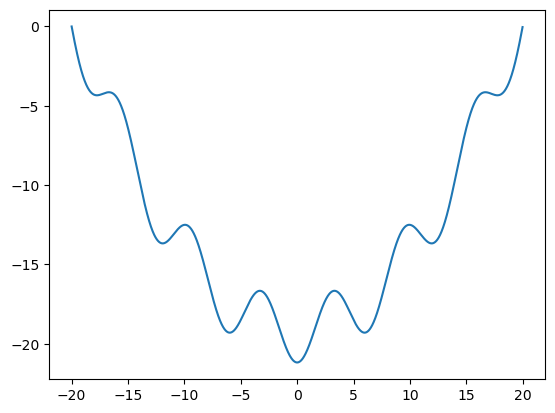

In [28]:
plt.plot(t_train, Y)

In [29]:
N_u = 25
layers = [1, 128, 1]

# create training set
idx = np.random.choice(X.shape[0], N_u, replace=False)
# Append boundary points
idx = np.concatenate((idx, [0, X.shape[0]-1]))
X_u_train = X[idx, :]
u_train = Y[idx, :]

model_DNN = DNN(layers)
loss_fn = torch.nn.MSELoss()  # mean square error
optimizer = torch.optim.Adam(model_DNN.parameters())

nIter = 100000
model_DNN.train()
for epoch in range(nIter + 1):
    inp = torch.tensor(X_u_train, requires_grad=True).float().to(device)
    y_pred = model_DNN(inp)
    loss = loss_fn(y_pred, torch.tensor(u_train, dtype=torch.float32))
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.3e}")

Epoch 0 -> Loss: 1.812e+02
Epoch 10000 -> Loss: 5.449e-01
Epoch 20000 -> Loss: 3.577e-01
Epoch 30000 -> Loss: 1.734e-01
Epoch 40000 -> Loss: 1.450e-01
Epoch 50000 -> Loss: 1.212e-01
Epoch 60000 -> Loss: 9.447e-02
Epoch 70000 -> Loss: 6.756e-02
Epoch 80000 -> Loss: 4.881e-02
Epoch 90000 -> Loss: 3.925e-02
Epoch 100000 -> Loss: 3.474e-02


In [30]:
model_DNN.eval()
Y_pred_DNN = model_DNN(torch.tensor(X, dtype=torch.float32))

In [31]:
# training
PINN_model = PhysicsInformedNN(X_u_train, u_train, layers)
PINN_model.train(nIter)

Epoch 0 -> Loss: 1.622e+02
Epoch 10000 -> Loss: 2.175e+00
Epoch 20000 -> Loss: 4.951e-01
Epoch 30000 -> Loss: 2.657e-02
Epoch 40000 -> Loss: 7.830e-03
Epoch 50000 -> Loss: 5.068e-03
Epoch 60000 -> Loss: 2.467e-03
Epoch 70000 -> Loss: 1.491e-03
Epoch 80000 -> Loss: 1.154e-03
Epoch 90000 -> Loss: 9.284e-04
Epoch 100000 -> Loss: 7.653e-04


In [32]:
Y_pred_PINN, f_pred_PINN = PINN_model.predict(X)

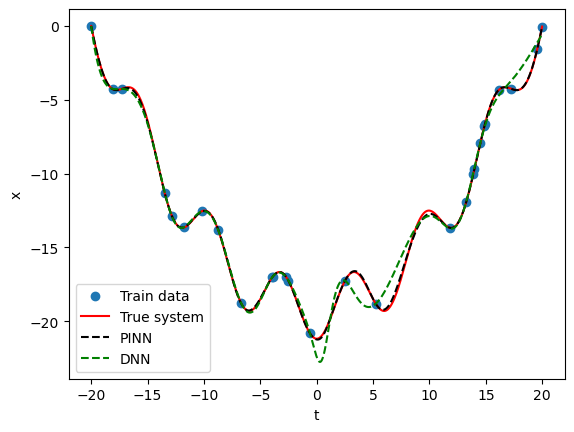

In [33]:
plt.plot(X_u_train, u_train, 'o', label='Train data')
plt.plot(t_train, Y, 'r', label='True system')
plt.plot(t_train, Y_pred_PINN, 'k--', label='PINN')
plt.plot(t_train, Y_pred_DNN.detach().numpy(), 'g--', label='DNN')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

With Physically-Informed Neural Networks, due to the regularization term which enforces the dynamical system, we see that we can more accurately describe the dynamical system, even for those areas where we do not have data.